In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_ma import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15
import pandas as pd

In [2]:
file_name = 'sanity_two_body_bar_1kpc_long'
seed = 0
cutoff = 200

In [3]:
results_file = f'runs/Dynamics-v0__{file_name}_best_performers.csv'

In [4]:
def make_env(seed):
        def thunk():
            env = Dynamics(hyperparameters={
                'stationary_potential_list':['bar'],
                'stationary_potential_kwargs_list':[{'M':1e10, 'a':5000, 'b':1500, 'c':1000, 'omega_p':0.0}],
                # 'stationary_potential_list':['point_source'],
                # 'stationary_potential_kwargs_list':[{'M':1e10}],
                # 'stationary_potential_list':[],
                # 'stationary_potential_kwargs_list':[{}],
                'dynamic_potential_list':['point_source','point_source'],
                # 'dynamic_potential_list':['tracer','tracer'],
                'dynamic_potential_kwargs_list':[{'M':1e10}, {'M':1e10}],
                'seed':seed,
                'box_scaling':100,
                'orbit_duration':1000,
                'orbit_timesteps':1000,
            })
            env.action_space.seed(seed)
            env.observation_space.seed(seed)
            return env
        return thunk
env = make_env(seed=seed)()

def plot_from_init(init_params):
    env.reset()
    print(init_params)
    init_params = {key:value/env.high for key,value in init_params.items()}
    _, reward, _, _, info = env.step(init_params)
    orbit = info['orbit']
    orbit_delta = info['orbit_delta']
    reverse_orbit_init_params = orbit.y[:,-1]
    reverse_orbit_delta_init_params = orbit_delta.y[:,-1]
    # reverse_orbit = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    # reverse_orbit_delta = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_delta_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    fig = plt.figure(figsize=(30, 10))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    for agent in range(env.num_agents):
        ax1.plot(orbit.y[agent*6][:cutoff], orbit.y[agent*6+1][:cutoff], orbit.y[agent*6+2][:cutoff], lw=0.5, label=r'$O_%d$'%agent)
        ax1.plot(orbit_delta.y[agent*6][:cutoff], orbit_delta.y[agent*6+1][:cutoff], orbit_delta.y[agent*6+2][:cutoff], lw=0.5, label=r'$O_{\delta%d}$'%agent)
        ax1.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], orbit.y[agent*6+2][0], label='Trajectory %d start'%agent)
    ax2 = fig.add_subplot(132)
    
    # ax2.scatter(0, 0, label='Source')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Projected Orbit')
    for agent in range(env.num_agents):
        ax2.plot(orbit.y[agent*6+0][:cutoff], orbit.y[agent*6+1][:cutoff], lw=2, label=r'$O_%d$'%agent)
        ax2.plot(orbit_delta.y[agent*6+0][:cutoff], orbit_delta.y[agent*6+1][:cutoff], lw=2, label=r'$O_{\delta%d}$'%agent)
        ax2.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], label='Trajectory %d start'%agent)
    ax1.set_title(f'3D Orbit')

    # ax3 = fig.add_subplot(133)
    # ax3.plot((orbit.y-reverse_orbit.y).sum(axis=0))
    # ax3.set_title(f'Orbit-reverse-orbit distances: {(orbit.y - reverse_orbit.y).sum()}')
        
    print(reward)
    ax1.legend()
    ax2.legend()
    # ax3.legend()

[ENV] Using cpu
[ENV] Seed set to 0


Text(0.5, 1.0, 'Initial positions studied, projected on the XY plane')

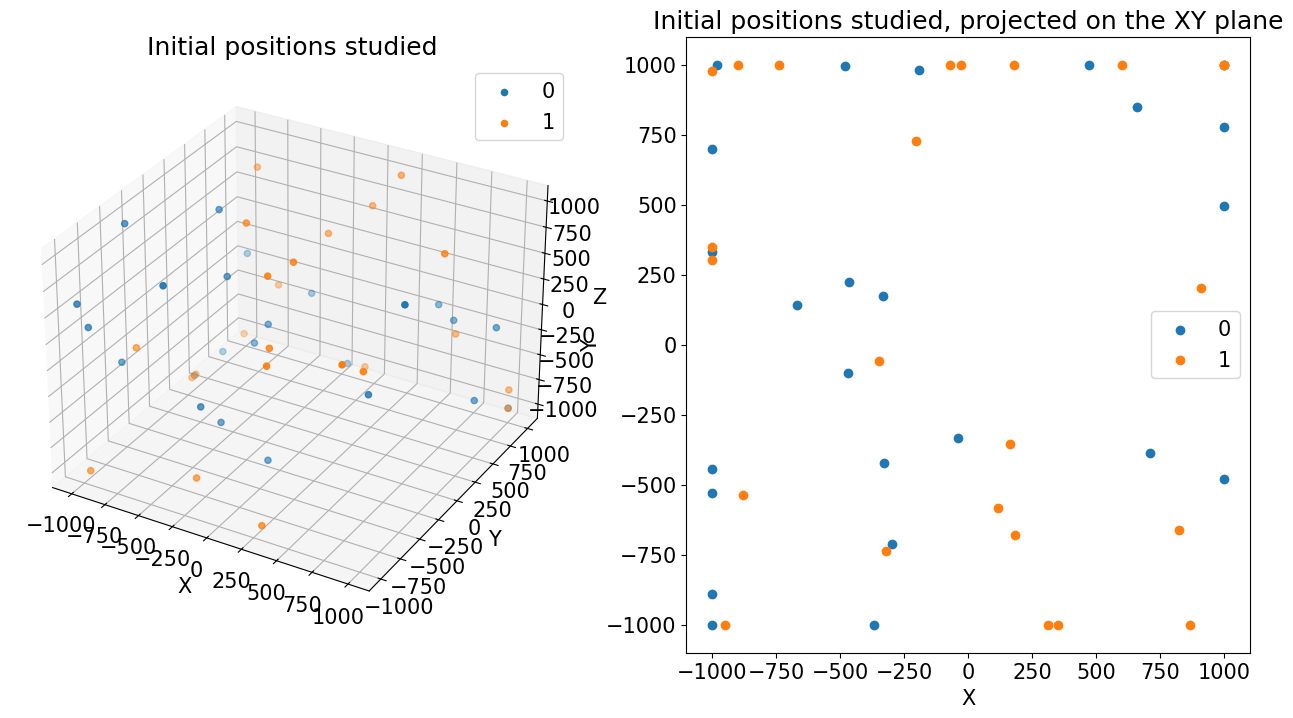

In [5]:
results = pd.read_csv(results_file).sort_values(by=['reward'], ascending=False)
result_init_params = {i:results.iloc[:, [j for j in range(i * 6+1, (i+1) * 6 + 1)]].to_numpy().transpose() for i in range(env.num_agents)}
result_init_params['reward'] = results.loc[:,'reward'].to_numpy()
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
for agent in range(env.num_agents):
    ax1.scatter(result_init_params[agent][0], result_init_params[agent][1], result_init_params[agent][2], label='%d'%agent)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()
ax1.set_title('Initial positions studied')

ax2 = fig.add_subplot(122)
for agent in range(env.num_agents):
    ax2.scatter(result_init_params[agent][0], result_init_params[agent][1], label='%d'%agent)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()
ax2.set_title('Initial positions studied, projected on the XY plane')

In [6]:
def result_to_init(i):
    return {agent:(result_init_params[agent][:,i]) for agent in range(env.num_agents)}

{0: array([-982.17529297, 1000.        , -178.1734314 ,    9.01480865,
         49.41583633,  100.        ]), 1: array([ 162.04144287, -353.43008423, 1000.        ,  100.        ,
        100.        ,  100.        ])}
{0: np.float64(3.7849759344503315e-18), 1: np.float64(1.0741284576880855e-16)}


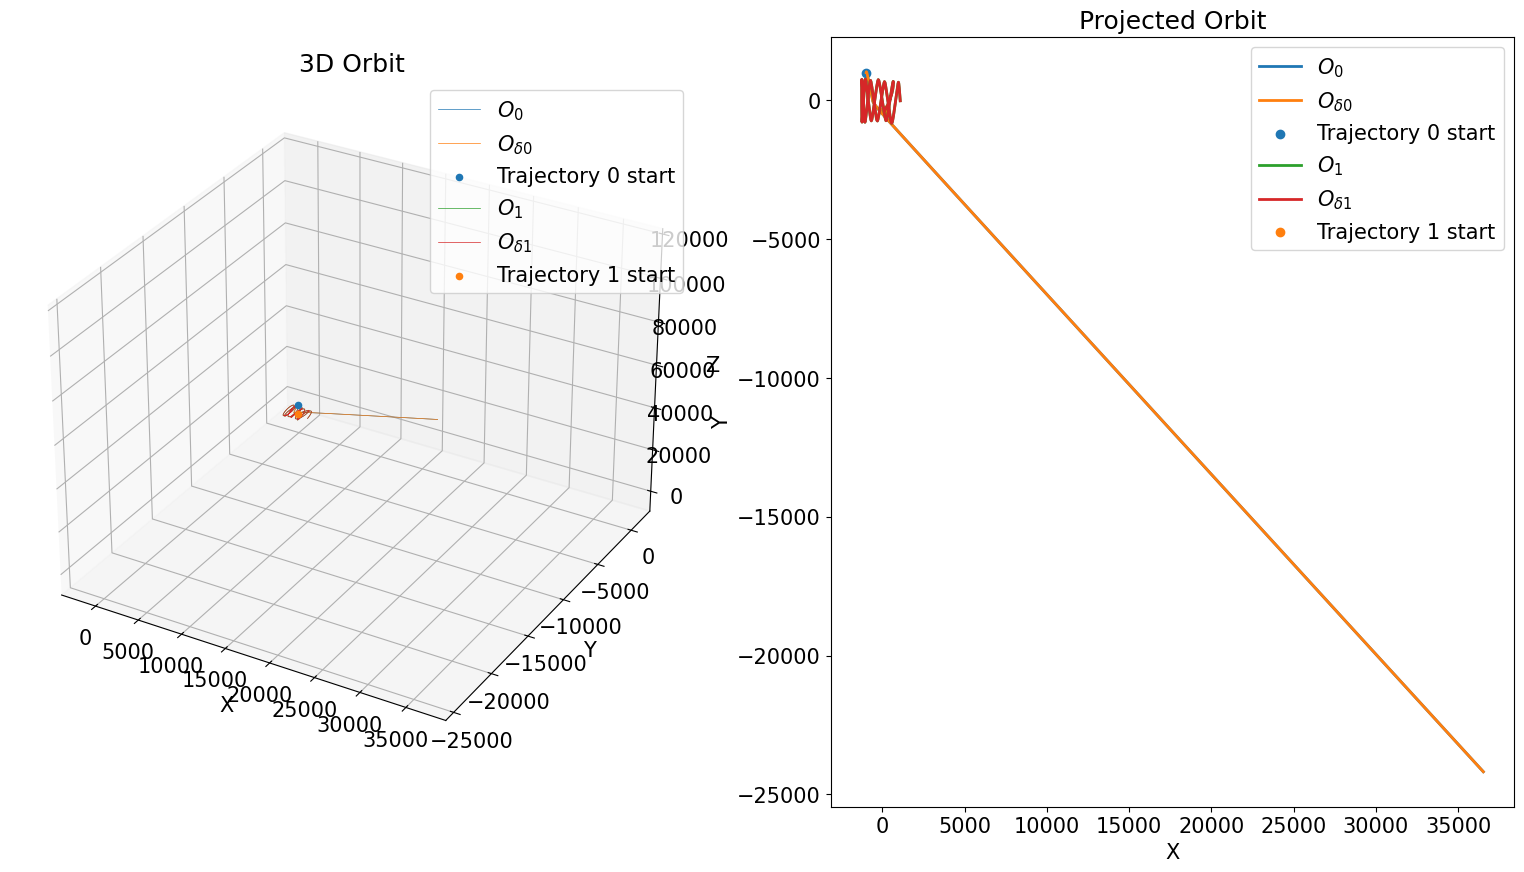

In [7]:
plot_from_init(result_to_init(0))

In [8]:
# init_params = {0:np.array([1000,0,0,0,1,0]), 1:np.array([-1000,0,0,0,-1,0])}
# plot_from_init(init_params)

{0: array([-330.07366943, -423.01318359, -678.6519165 ,   71.21914673,
         89.27313232,  100.        ]), 1: array([ 1000.        ,  1000.        , -1000.        ,    75.87741852,
          76.51077271,   100.        ])}
{0: np.float64(2.6081054583741055e-17), 1: np.float64(8.324439786390832e-17)}


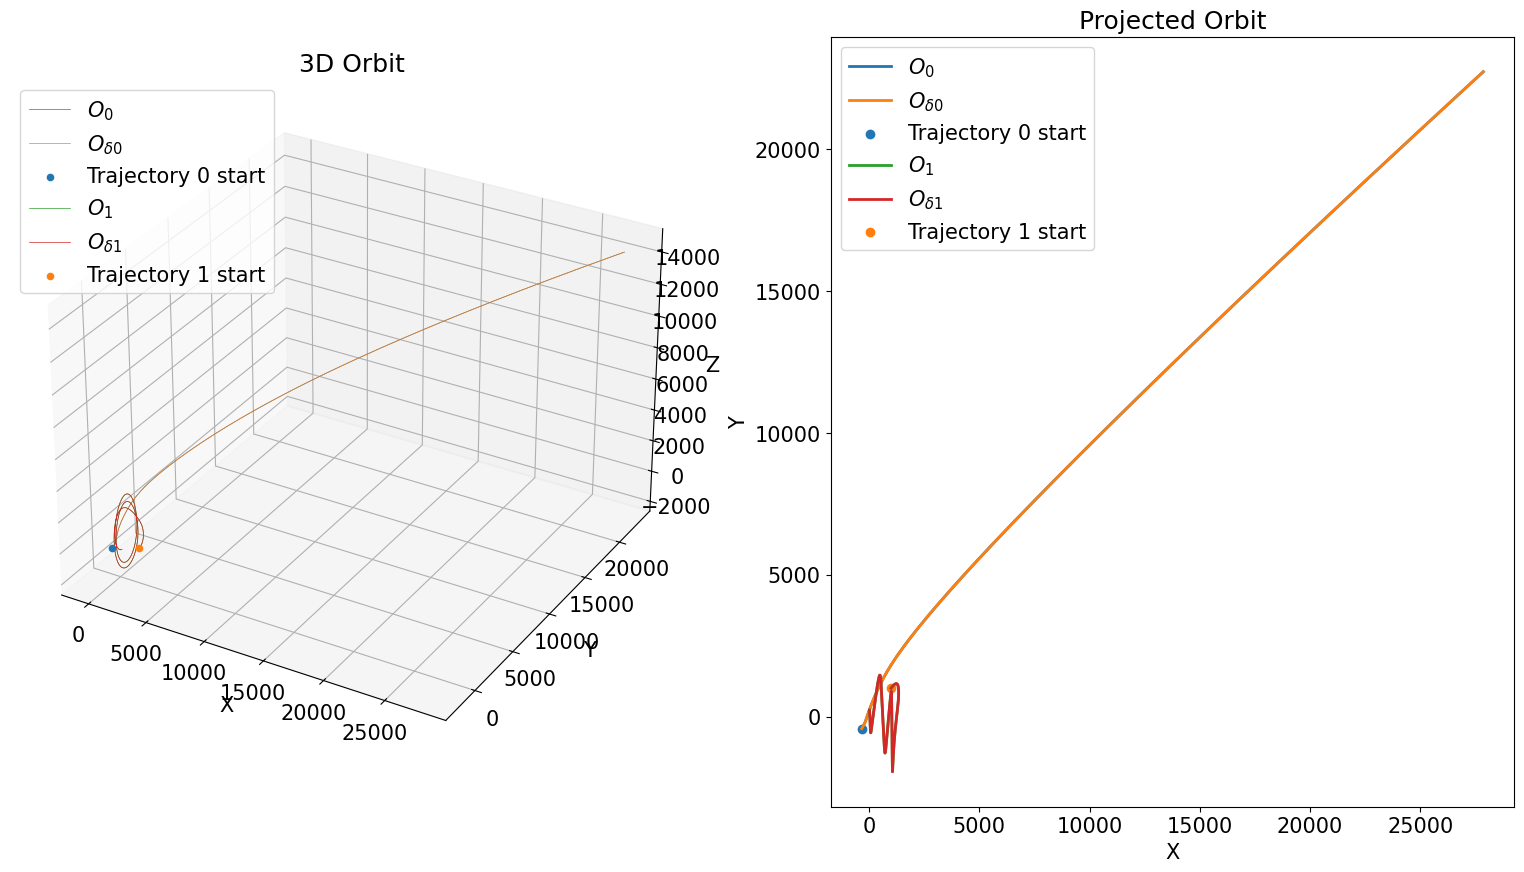

In [9]:
plot_from_init(result_to_init(1))

{0: array([-1000.        ,  -888.54571533,   298.92724609,  -100.        ,
           1.14382017,  -100.        ]), 1: array([ 824.0892334 , -662.4576416 ,  440.59710693,  -76.88021851,
        -69.05020142,  -25.72304535])}
{0: np.float64(1.2114619925274611e-17), 1: np.float64(9.002844105810297e-18)}


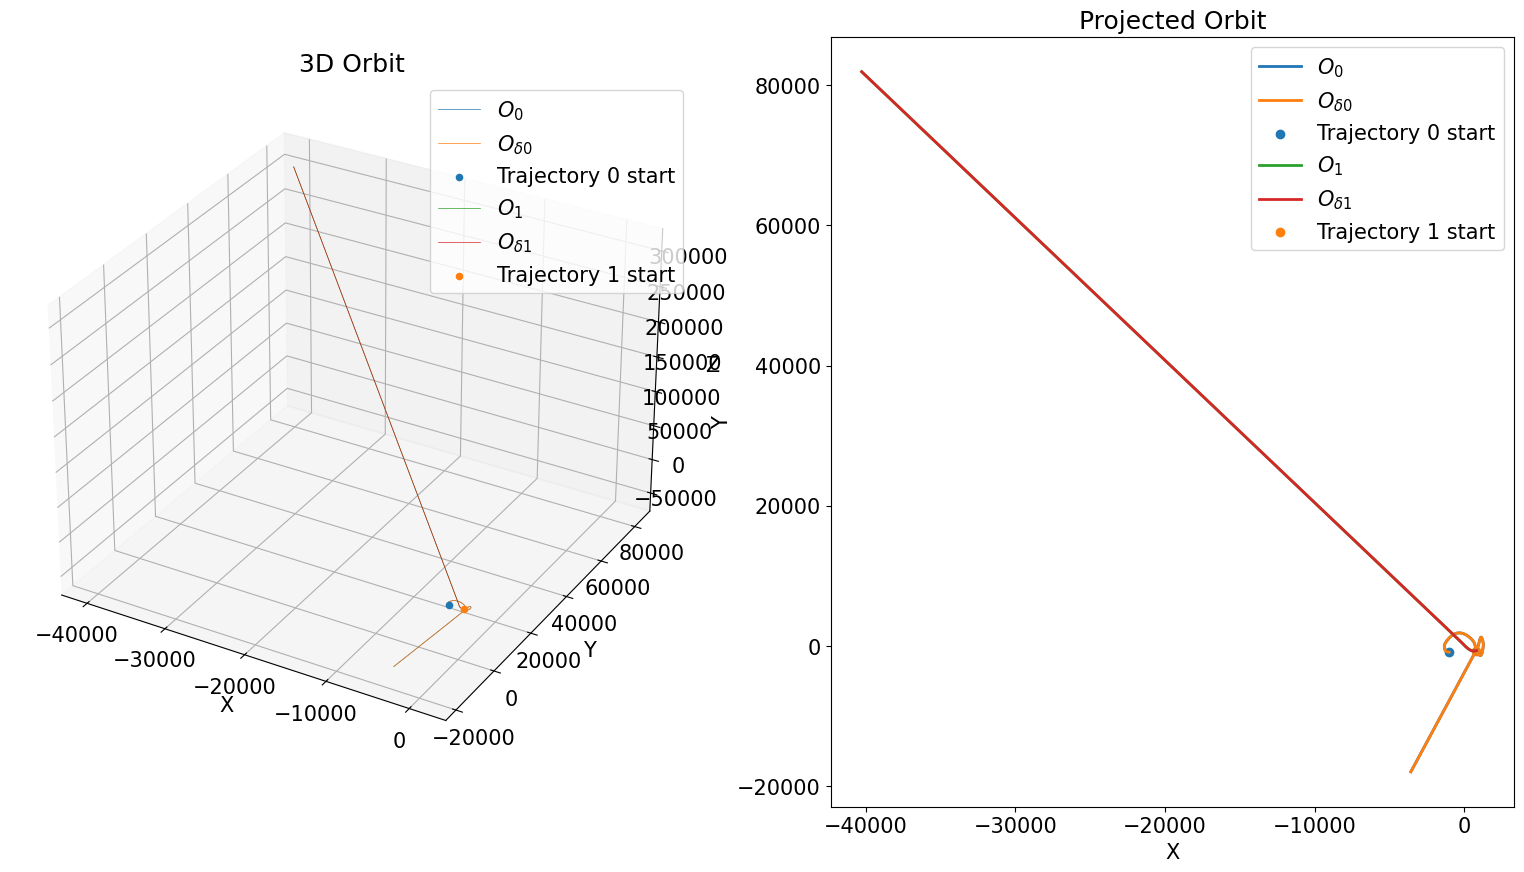

In [10]:
plot_from_init(result_to_init(2))

{0: array([-1000.        ,   697.45068359, -1000.        ,   -87.56308746,
         -43.79096222,   100.        ]), 1: array([  866.11627197, -1000.        ,   750.27740479,   100.        ,
         100.        ,   -17.43932724])}
{0: np.float64(2.6833739224014517e-17), 1: np.float64(1.2556320606709856e-17)}


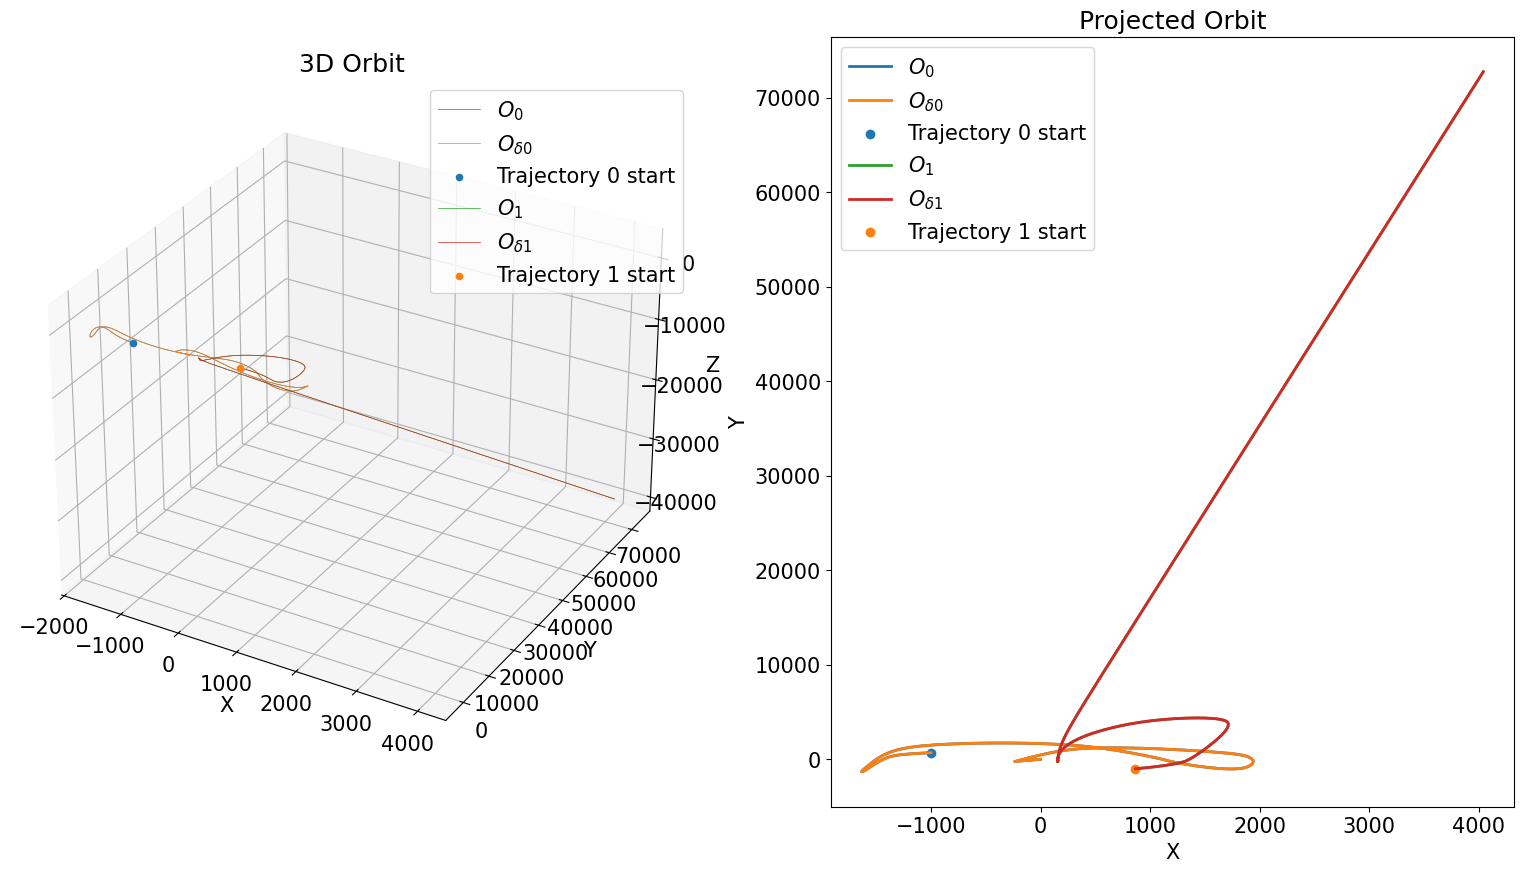

In [11]:
plot_from_init(result_to_init(3))

{0: array([ -367.39944458, -1000.        ,  1000.        ,   -55.44441986,
          62.08884048,   -82.65029907]), 1: array([-347.82595825,  -59.23236847, 1000.        , -100.        ,
       -100.        ,  100.        ])}
{0: np.float64(1.310897683148249e-17), 1: np.float64(1.317261537551654e-17)}


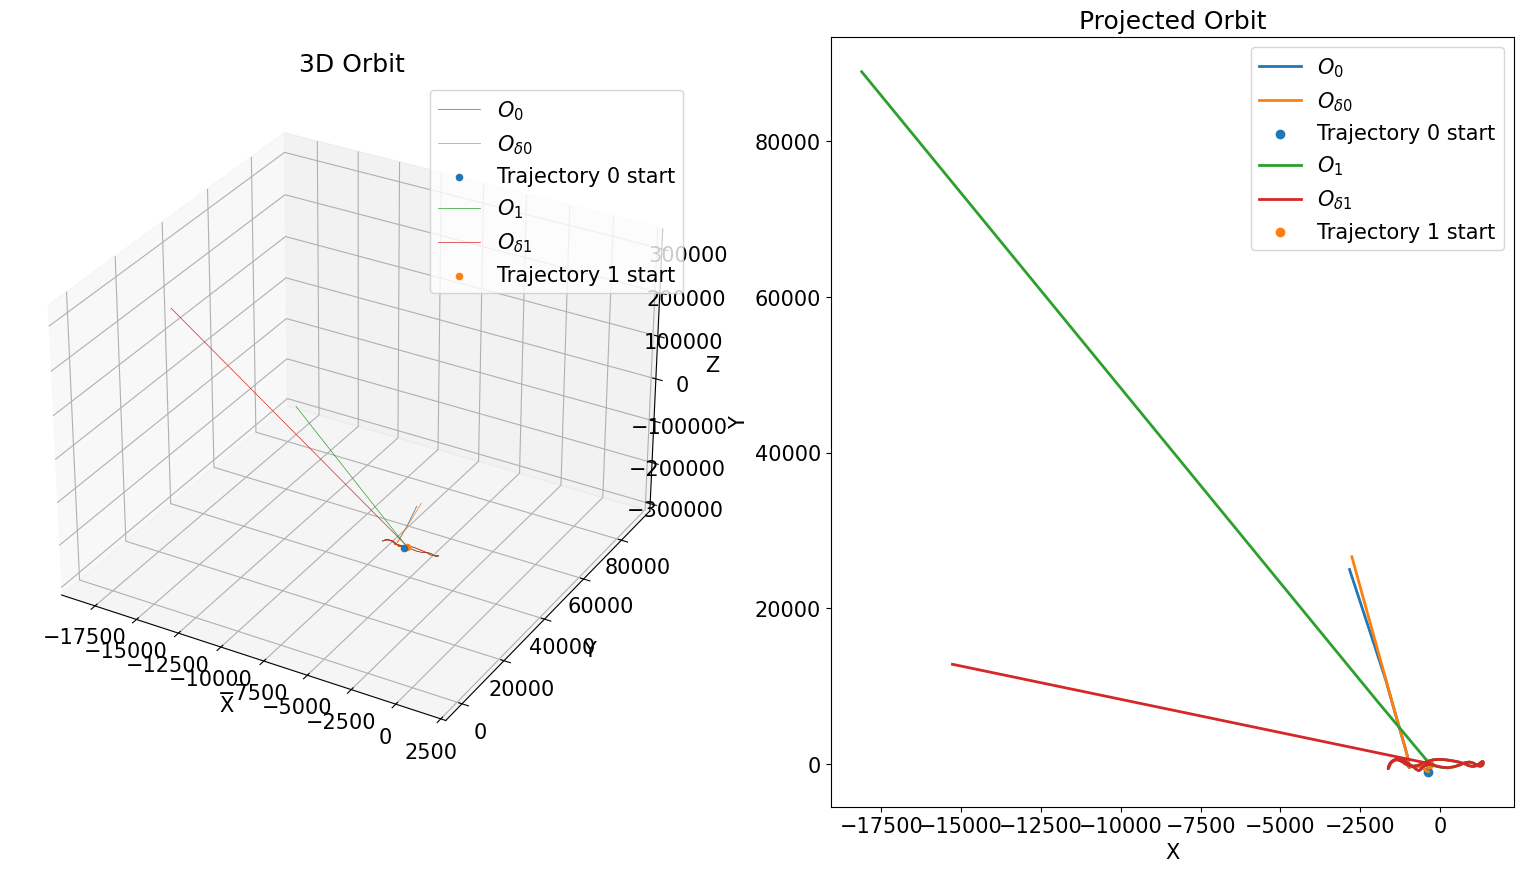

In [12]:
plot_from_init(result_to_init(4))

{0: array([1000.        , -479.90380859, 1000.        ,   16.82905579,
        -48.10994339,  -42.27106476]), 1: array([-739.33728027, 1000.        , -411.50897217,   63.2247467 ,
          7.09034634,  100.        ])}
{0: np.float64(8.621152018170718e-18), 1: np.float64(1.1854511685553917e-17)}


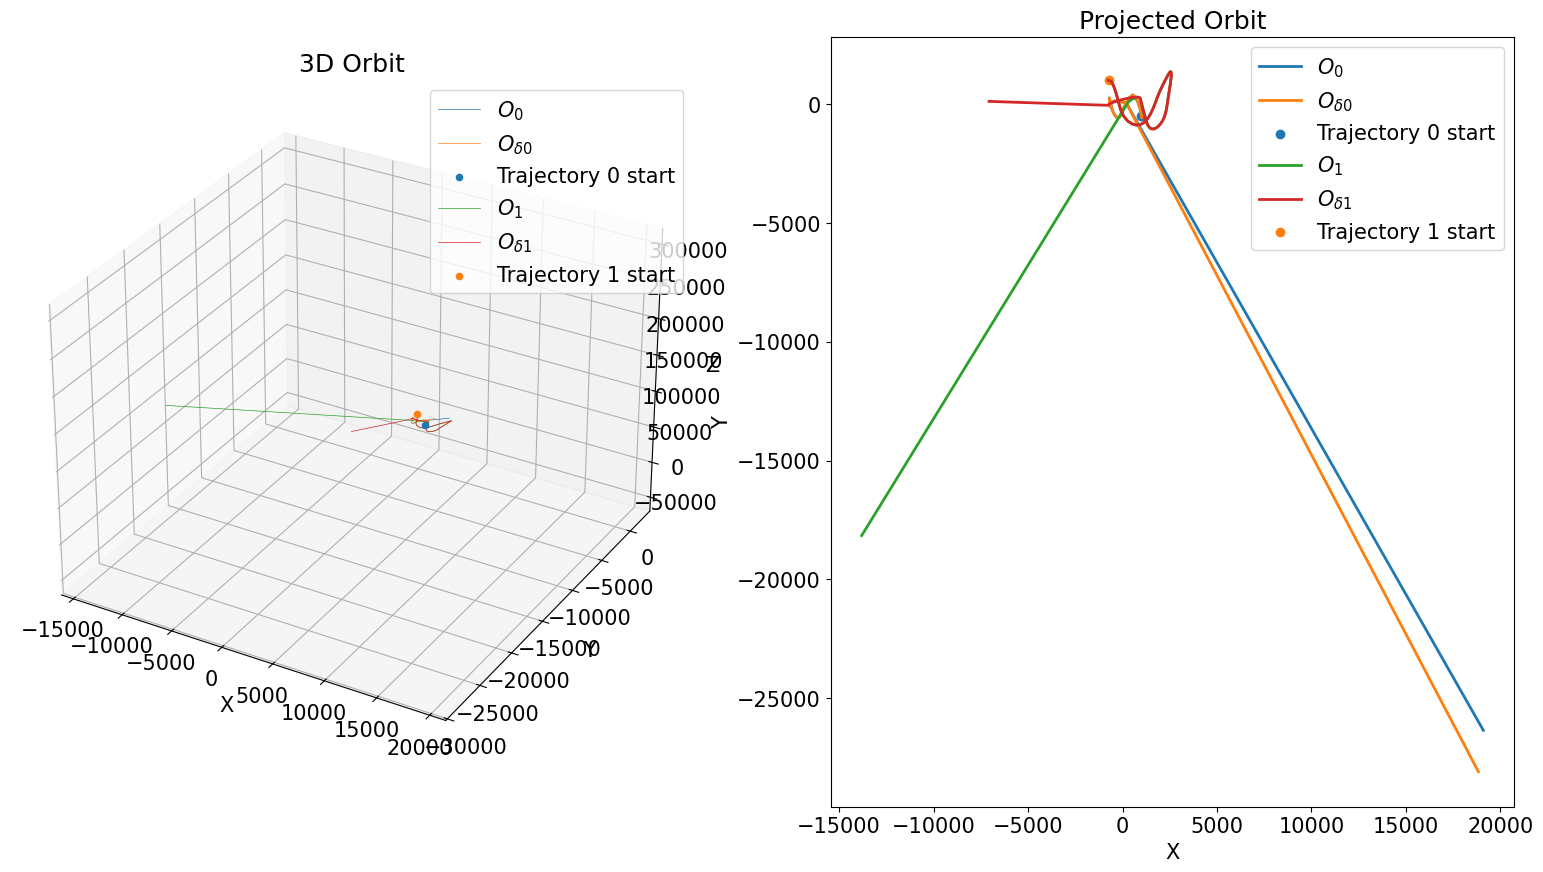

In [13]:
plot_from_init(result_to_init(5))